<a href="https://colab.research.google.com/github/Shitrasburg/map/blob/main/Lab3_walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab 3 走路學問多

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import shutil
import folium#地圖
import io
import glob
from scipy.signal import find_peaks, peak_prominences
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# DataPath = '/content/drive/MyDrive/Map/Lab3/Data/'

prefix = '/content/drive/MyDrive/mapLab3/'

DATA_DIR = prefix + 'Data/'
RESULT_DIR = prefix + 'Result/'


In [123]:
def loadData(filepath):
    round = pd.read_csv(filepath)
    r = round.ffill()
    # r = r.iloc[400:-400]
    r = r.reset_index(drop=True)

    return r

def calculateG(r,groupName):
    r["g"] = (r["Accelerometer_x"]*r["Accelerometer_x"] + r["Accelerometer_y"]*r["Accelerometer_y"] + r["Accelerometer_z"]*r["Accelerometer_z"] )**0.5 #You can change this
    # r.plot(x='Timestamp', y=['g'])
    # plt.title(groupName)
    return r

#Task 1
def find_step_our(r, savePath, step_distance):

    # 讀取數據
    data = r
    # 設置閥值
    threshold = 0.05

    # 找出波峰和波谷的索引
    peaks, _ = find_peaks(data['g'], height=0.2,distance=2) # height表示峰值的閥值，這裡設為0，distance表示相鄰峰值之間的最小距離，這裡設為10
    # print (len(peaks))
    troughs = []
    for i in range(1, len(data['g'])-1):
        if data['g'][i] < data['g'][i-1] and data['g'][i] < data['g'][i+1]:
            troughs.append(i)
        elif data['g'][i] == data['g'][i-1] and data['g'][i] < data['g'][i+1]:
            troughs.append(i)
    # print(f"troughs:{len(troughs)}")
    # 儲存偵測到的步數的資訊
    steps_info = []

    # 從第一個波峰開始檢測
    for p in peaks:
        # 找到這個波峰左邊最近的波谷
        left_trough_idx = None
        for i in range(p-1, -1, -1):
            if i in troughs:
                left_trough_idx = i
                break
        if left_trough_idx is None:
            continue
        low_left = data.iloc[left_trough_idx]['g']
        time_left = r['Timestamp'][left_trough_idx]
        # 找到這個波峰右邊最近的波谷
        right_trough_idx = None
        for i in range(p+1, len(data['g'])):
            if i in troughs:
                right_trough_idx = i
                break
        if right_trough_idx is None:
            continue
        low_right = data.iloc[right_trough_idx]['g']
        time_right = r['Timestamp'][right_trough_idx]

        sum_x,sum_y,sum_z = 0,0,0
        avg_g_x,avg_g_y,avg_g_z = 0,0,0
        avg_m_x,avg_m_y,avg_m_z = 0,0,0

        for i in range(left_trough_idx , right_trough_idx+1): #計算這一步內的 平均加速度avg_g 的x,y,z各分量
            sum_x += r["Accelerometer_x"][i]
            sum_y += r["Accelerometer_y"][i]
            sum_z += r["Accelerometer_z"][i]
        avg_g_x = sum_x/(right_trough_idx-left_trough_idx+1)
        avg_g_y = sum_y/(right_trough_idx-left_trough_idx+1)
        avg_g_z = sum_z/(right_trough_idx-left_trough_idx+1)
        for i in range(left_trough_idx , right_trough_idx+1): #計算這一步內的 平均磁力計avg_m 的x,y,z各分量
            sum_x += r["Magnetometer_x"][i]
            sum_y += r["Magnetometer_y"][i]
            sum_z += r["Magnetometer_z"][i]
        avg_m_x = sum_x/(right_trough_idx-left_trough_idx+1)
        avg_m_y = sum_y/(right_trough_idx-left_trough_idx+1)
        avg_m_z = sum_z/(right_trough_idx-left_trough_idx+1)
        # 計算這個振幅是否大於閥值

        if data.iloc[p]['g']-low_left > threshold and data.iloc[p]['g']-low_right >threshold:
            # 記錄相關資訊
            #step_info = {
                
                #'Amplitude': amplitude,
                #'low_left': left_trough,
                #,
                #'low_right': right_trough,
                #'time_left':int(time_left),
                #'time_right': int(time_right),
                #'step_distance':50,
                #'avg_g_x':avg_g_x,
                #'avg_g_y':avg_g_y,
                #'avg_g_z':avg_g_z,
                #'avg_m_x':avg_m_x,
                #'avg_m_y':avg_m_y,
                #'avg_m_z':avg_m_z,
                #'timestamp':data.iloc[p]['Timestamp']
            #}
            #steps.append(step_info)
            peak = data.iloc[p]['g']
            lat = data.iloc[p]['Latitude']
            lng = data.iloc[p]['Longitude']
            steps_info.append([low_left,peak,low_right,time_left,time_right,step_distance,avg_g_x,avg_g_y,avg_g_z,avg_m_x,avg_m_y,avg_m_z, lat, lng])

    # 將步數資訊轉換成DataFrame
    steps_df = pd.DataFrame(steps_info)

    # 顯示偵測到的步數資訊
    # print(steps_df)


    # 将Timestamp转换成datetime格式并设置为索引
    #data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    data = data.set_index('Timestamp')

    # 画出data['g']的曲线
    steps_df = pd.DataFrame(steps_info)

    for step in steps_info:
        plt.plot(step[3], step[1], 'rx')  # plot peak as a red cross
        plt.plot(step[4], step[0], 'gx')  # plot low_left as a green cross
        plt.plot(step[4], step[2], 'go')  # plot low_right as a green cross

    plt.legend()
    # plt.show()

    plt.savefig(savePath + "/step_observer.png")

    save_step_data(steps_info, savePath, 'step_info.csv')


def find_step_use_ta(r, savePath, step_distance):
    threshold = 0.18
    #frequency = 200
    low_left = 0
    low_right = 0
    time_left = 0
    time_right = 0
    peak = 0
    # step_distance = 30
    index_left = 0
    index_right = 0
    step_info=[]

    # print(len(r['g']))
    print("savePath:{}".format(savePath))
    for i in range(1,len(r['g'])):
        if i+4 >= len(r['g']): # out of bounds
            break
        if (r['g'][i] > r['g'][i-1]) and (r['g'][i] > r['g'][i+4]):  #find peak
            peak = r['g'][i]

            for j in range(1,30): #to right side
                if i+j+4 >= len(r['g']):
                    break
                if r['g'][i+j] < r['g'][i+j+4] and r['g'][i+j] < r['g'][i+j-1]:
                    low_right = r['g'][i+j]
                    time_right = r['Timestamp'][i+j]
                    index_right = i+j
                    break
            for j in range(1,30): #to left side
                if i-j-1 < 0 :
                    break
                if r['g'][i-j] < r['g'][i-j+4] and r['g'][i-j] < r['g'][i-j-1]:
                    low_left = r['g'][i-j]
                    time_left = r['Timestamp'][i-j]
                    index_left = i-j
                    break
            sum_x,sum_y,sum_z = 0,0,0
            avg_g_x,avg_g_y,avg_g_z = 0,0,0
            avg_m_x,avg_m_y,avg_m_z = 0,0,0

            for i in range(index_left , index_right+1): #計算這一步內的 平均加速度avg_g 的x,y,z各分量
                sum_x += r["Accelerometer_x"][i]
                sum_y += r["Accelerometer_y"][i]
                sum_z += r["Accelerometer_z"][i]
            avg_g_x = sum_x/(index_right-index_left+1)
            avg_g_y = sum_y/(index_right-index_left+1)
            avg_g_z = sum_z/(index_right-index_left+1)
            for i in range(index_left , index_right+1): #計算這一步內的 平均磁力計avg_m 的x,y,z各分量
                sum_x += r["Magnetometer_x"][i]
                sum_y += r["Magnetometer_y"][i]
                sum_z += r["Magnetometer_z"][i]
            avg_m_x = sum_x/(index_right-index_left+1)
            avg_m_y = sum_y/(index_right-index_left+1)
            avg_m_z = sum_z/(index_right-index_left+1)

            lat = r['Latitude'][index_left]
            lng = r['Longitude'][index_left]

            if peak - low_left > threshold and peak - low_right > threshold:  #若振幅大於設定的閥值就把這一步記錄下來 並放進list保存 待會輸出成output
                step_info.append([low_left,peak,low_right,time_left,time_right,step_distance,avg_g_x,avg_g_y,avg_g_z,avg_m_x,avg_m_y,avg_m_z, lat, lng])

    # print(step_info)
    # for step in step_info:
    #     plt.plot(step[3], step[1], 'rx')  # plot peak as a red cross
    #     plt.plot(step[4], step[0], 'gx')  # plot low_left as a green cross
    #     plt.plot(step[4], step[2], 'go')  # plot low_right as a green cross

    # plt.legend()
    # # plt.show()

    # plt.savefig(savePath + "/step_ta_observer.png")
    save_step_data(step_info, savePath, "step_info_ta.csv")

def find_step(r, save_path, step_distance):

    print(step_distance)

    # find_step_our(r, save_path, step_distance)
    find_step_use_ta(r, save_path, step_distance)
    return



def save_step_data(r, save_path, filename):
    output = {
        "Step":[],
        "TimeSpend":[],
        "Amp_left":[],
        "Amp_right":[],
        "Peak":[],
        "Timestamp":[],
        "Avg_g_x":[],
        "Avg_g_y":[],
        "Avg_g_z":[],
        "Avg_m_x":[],
        "Avg_m_y":[],
        "Avg_m_z":[],
        "Step_Distance":[],
        "lat":[],
        "lng":[]
    }
    df = pd.DataFrame(output)
    step_count = 1

    for i in r:
        new_df = pd.DataFrame({
            "Step":[step_count],   #偵測到的第幾步
            "TimeSpend":i[4] - i[3],#一步所花的時間
            "Amp_left":[i[0]],    #左振幅
            "Amp_right":[i[2]],    #右振幅
            "Peak":[i[1]],      #波峰
            "Timestamp":[str(i[3])+"-"+ str(i[4])],  #時間戳記
            "Avg_g_x":i[6],
            "Avg_g_y":i[7],
            "Avg_g_z":i[8],
            "Avg_m_x":i[9],
            "Avg_m_y":i[10],
            "Avg_m_z":i[11],
            "lat":i[12],
            "lng":i[13],
            "Step_Distance":i[5],    #步距
            
        })
        df = pd.concat([df,new_df],ignore_index=True)
        step_count=step_count+1
    print("error")
    save_file_path = save_path + "/" + filename
    df.to_csv(save_file_path, index=False)  ##輸出結果檔名要記得
    
    # Go Task 3
    print("save_file_path:{0}".format(save_file_path))
    # orientation(save_file_path)

#Task 2
def trainModel(dir, file_name):
    files = [] #glob("/content/drive/MyDrive/Map/Lab3/Result/*_cm.csv")
    for d in os.listdir(dir):
        files.append(dir + d + "/" + file_name)

    # print(files)

    # return

    df_list = [pd.read_csv(file) for file in files]

    df = pd.concat(
        (pd.read_csv(file,usecols=['TimeSpend','Amp_left','Amp_right',"Peak","Step_Distance"],dtype={'TimeSpend':float,'Amp_left':float,'Amp_right':float,'Peak':float,'Step_Distance':float})for file in files),ignore_index=True)

    X = df.iloc[:,:-1].values#取到最後一個欄位的整筆row
    Y = df.iloc[:,-1].values#取最後一個欄位全部的資料

    test_size = 0.3

    ## LinearRegression
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=test_size,random_state=777) #設定訓練大小為0.8 測試大小為0.2

    reg = LinearRegression()
    reg.fit(X_train,Y_train)
    Y_pred = reg.predict(X_test)

    np.set_printoptions(precision=2) #設定預測精準度到小數點後第2位
    print(np.concatenate((Y_pred.reshape(len(Y_pred),1),Y_test.reshape(len(Y_test),1)),1)) #左邊為預測結果 右邊為真實結果
    # mse = mean_squared_error(Y_test, Y_pred)
    ## 迴歸模型的準確度
    score = reg.score(X_test, Y_test)
    print('Score: ', score)
    print('Accuracy: ' + str(score*100) + '%')
    print("[LinearRegression]Mean squared error: {:.2f}".format(mean_squared_error(Y_pred, Y_test)))
    ## SVR
    # X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=test_size,random_state=777) #設定訓練大小為0.8 測試大小為0.2
    # svr = SVR(kernel='rbf', gamma='scale', C=1.0, epsilon=0.2)
    # svr.fit(X_train, Y_train)
    # Y_pred = svr.predict(X_test)

    # np.set_printoptions(precision=2) #設定預測精準度到小數點後第2位
    # #print(np.concatenate((Y_pred.reshape(len(Y_pred),1),Y_test.reshape(len(Y_test),1)),1)) #左邊為預測結果 右邊為真實結果
    # mse = mean_squared_error(Y_test, Y_pred)
    # print("[SVR]Mean squared error: {:.2f}".format(mse))

    # ## RandomForestRegressor
    # X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=test_size,random_state=777) #設定訓練大小為0.8 測試大小為0.2

    # rf = RandomForestRegressor(n_estimators=100, random_state=777)
    # rf.fit(X_train, Y_train)
    # Y_pred = rf.predict(X_test)

    # np.set_printoptions(precision=2) #設定預測精準度到小數點後第2位
    # #print(np.concatenate((Y_pred.reshape(len(Y_pred),1),Y_test.reshape(len(Y_test),1)),1)) #左邊為預測結果 右邊為真實結果
    # mse = mean_squared_error(Y_test, Y_pred)
    # print("[RandomForestRegressor]Mean squared error: {:.2f}".format(mse))

    # ## MLPRegressor
    # X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=test_size,random_state=777) #設定訓練大小為0.8 測試大小為0.2

    # mlp = MLPRegressor(hidden_layer_sizes=(100,50), max_iter=500, activation='relu', solver='adam', random_state=777)
    # mlp.fit(X_train, Y_train)
    # Y_pred = mlp.predict(X_test)

    # np.set_printoptions(precision=2) #設定預測精準度到小數點後第2位
    # #print(np.concatenate((Y_pred.reshape(len(Y_pred),1),Y_test.reshape(len(Y_test),1)),1)) #左邊為預測結果 右邊為真實結果
    # mse = mean_squared_error(Y_test, Y_pred)
    # print("[MLPRegressor]Mean squared error: {:.2f}".format(mse))


# Task 3
def orientation(path):
  dir_list = []
  print("orientation path:{}".format(path))
  new_df=pd.read_csv(path+"/step_info_ta.csv")
  print("len(new_df[Step]):{}".format(len(new_df["Step"])))
  for i in range(len(new_df["Step"])):
    avg_g = np.array([new_df["Avg_g_x"][i], new_df["Avg_g_y"][i] ,new_df["Avg_g_z"][i]])
    avg_m = np.array([new_df["Avg_m_x"][i], new_df["Avg_m_y"][i] ,new_df["Avg_m_z"][i]])
    z = np.array([0,0,-1]) #z軸單位向量 與avg_g同向
    u = z - (np.dot(z,avg_g)/np.dot(avg_g,avg_g)*z) #重力加速度在水平方向分量 使用
    v = avg_m - ((np.dot(avg_g,avg_m)/np.dot(avg_g,avg_g))*avg_m) #磁力計在水平方向朝南 使用avg_m - (avg_m在avg_g的投影向量)
    cos = np.dot(u,v) / ((np.dot(u,u)**0.5) * np.dot(v,v)**0.5) #計算兩個COS值 使用高中所學公式
    cross_ans = np.dot(np.cross(v,u) , avg_g) #判斷夾角偏向東還是西 使用u與v外積後和avg_g內積 判斷正負值來得知往左還往右
    if cross_ans < 0: #與avg_m 反向 右手定則由南邊往左偏移
      if cos >=0.7071 and cos <=1:
        dir = "南"
      elif cos <0.7071 and cos >0:
        dir = "東"
      elif cos <0 and cos >=-0.7071:
        dir = "東"
      elif cos < -0.7071 and cos >-1:
        dir = "北"
    elif cross_ans > 0: #與avg_m 反向 右手定則由南邊往左偏移
      if cos >=0.7071 and cos <=1:
        dir = "南"
      elif cos <0.7071 and cos >0:
        dir = "西"
      elif cos <0 and cos >=-0.7071:
        dir = "西"
      elif cos < -0.7071 and cos >-1:
        dir = "北"
      dir_list.append(dir)
  orientationTXT=path+"/orientation.txt"
  print("dir_list:{}".format(dir_list))
  with open(orientationTXT, 'w') as fp:
    # write each item on a new line
    fp.write("%s\n" % dir_list)
  print('Done')
  # print(dir_list)
  #1 ~ 0.7071 0度~45度
  #0.7071 ~ 0 45度~90度
  #0 ~ -0.7071 90度 ~ 135度
  #-0.7071 ~ -1 135度~180度
###########



#Task 4 SHOW MAP
def showMap(file_path, save_path, save_name):

  # 設定地圖中心點座標
  center = [24.7868797,120.9974383]

  # ori_df = pd.read_csv("/content/drive/MyDrive/Map/Lab3/Data/05_50cm.csv")
  # print("map save_path:{}".format(save_path))
  # print("map file_path:{}".format(file_path))
  result_df = pd.read_csv(file_path)
  # mapData=pd.read_csv(RESULT_DIR+"70/step_info_70_cm.csv")
  # print(result_df.iloc[:, [13,14]])
  result_df=result_df.iloc[:, [13,14]].dropna()
  # print(result_df)
  #1681302721895-1681302722263 Result的欄位內容取前13字元
  # result_df['Timestamp'] = result_df['Timestamp'].str[:13].astype(int) 
  # print(result_df['Timestamp'])
  #print(result_df.dtypes)
  # merge_df = pd.merge(ori_df,result_df,left_on="Timestamp",right_on='Timestamp')
  # print(merge_df.dtypes)
  # merge_df = merge_df.dropna(subset=['Latitude'])
  # print(merge_df)
  # merge_df = merge_df.dropna(subset=['Longitude'])
  # print(merge_df)

  # 建立地圖物件，zoom_start 是縮放等級
  result_df.to_csv( save_path+"/result.txt", sep=',', index=False, header=True)
  map = folium.Map(location=center, zoom_start=40)
  # result_df=result_df.dropna()
  # 要標記的 GPS 位置列表
  result_dataframe = pd.read_csv(save_path+"/result.txt")
  locations = result_dataframe[['lat','lng']].values.tolist()
  if len(locations) > 0:
      map.add_child(folium.PolyLine(locations=locations, # 座標List
                            color='red',weight=5)) # 線條寬度
  # 在地圖上標記 GPS 位置
  # for location in locations:
  #     marker = folium.Marker(location=location)
  #     marker.add_to(map)
  # for location in locations:
  #     marker = folium.Marker(location=location)
      # marker.add_to(map)

      # map.add_child(folium.Circle(location=location,
      #             color='red', # Circle 顏色
      #               radius=0.9, # Circle 寬度
      #               #  popup='Skytree', # 彈出視窗內容
      #             fill=True, # 填滿中間區域
      #               fill_opacity=0 # 設定透明度
      #             ))
  # 顯示地圖
  
  map
  map.save(save_path + '/' + "route_map.html")

In [121]:

# Delete RESULT DIRECTORY
if os.path.exists(RESULT_DIR):
  print(RESULT_DIR)
  shutil.rmtree(RESULT_DIR)

# Task 1 and Task 3
for f in os.listdir(DATA_DIR):
    if '.ipynb_checkpoints' not in f and '.csv' in f:
        print("Now Handle CSV {}".format(f))
        
        csvDir = DATA_DIR + f
        groupName = f.replace(".csv", "")
        step_dis = groupName.split("_")[-1].replace("cm", "")
        resultDir = RESULT_DIR + groupName
        print("create result folder {}".format(resultDir))
        os.makedirs(resultDir)

        csvData = loadData(csvDir)
        csvData = calculateG(csvData,groupName)
        find_step(csvData, resultDir, step_dis)
        # print("resultDir:{}".format(resultDir))
        orientation(resultDir)
        # print(csvData)



/content/drive/MyDrive/mapLab3/Result/
Now Handle CSV 07_60cm.csv
create result folder /content/drive/MyDrive/mapLab3/Result/07_60cm
60
savePath:/content/drive/MyDrive/mapLab3/Result/07_60cm
error
save_file_path:/content/drive/MyDrive/mapLab3/Result/07_60cm/step_info_ta.csv
orientation path:/content/drive/MyDrive/mapLab3/Result/07_60cm
len(new_df[Step]):10
dir_list:['西', '西', '西']
Done
Now Handle CSV 08_60cm.csv
create result folder /content/drive/MyDrive/mapLab3/Result/08_60cm
60
savePath:/content/drive/MyDrive/mapLab3/Result/08_60cm
error
save_file_path:/content/drive/MyDrive/mapLab3/Result/08_60cm/step_info_ta.csv
orientation path:/content/drive/MyDrive/mapLab3/Result/08_60cm
len(new_df[Step]):148
dir_list:['北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '西', '西', '西', '西', '西', '西', '南', '西', '西', '西', '西', 

<ipython-input-120-fad26d77d55c>:346: RuntimeWarning: invalid value encountered in double_scalars
  u = z - (np.dot(z,avg_g)/np.dot(avg_g,avg_g)*z) #重力加速度在水平方向分量 使用
<ipython-input-120-fad26d77d55c>:347: RuntimeWarning: invalid value encountered in double_scalars
  v = avg_m - ((np.dot(avg_g,avg_m)/np.dot(avg_g,avg_g))*avg_m) #磁力計在水平方向朝南 使用avg_m - (avg_m在avg_g的投影向量)


error
save_file_path:/content/drive/MyDrive/mapLab3/Result/06_50cm/step_info_ta.csv
orientation path:/content/drive/MyDrive/mapLab3/Result/06_50cm
len(new_df[Step]):151
dir_list:['南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '南', '西', '西', '西', '西', '西', '西', '西', '西', '西', '北', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北']
Done
Now Handle CSV 05_50cm.csv
create result folder /content/drive/MyDrive/mapLab3/Result/05_50cm
50
savePath:/content/drive/MyDrive/mapLab3/Result/05_50cm
error
save_file_path:/content/drive/MyDrive/mapLab3/Result/05_50cm/step_info_ta.csv
orientation path:/content/drive/MyDrive/mapLab3/Result/05_50

In [124]:
# Task 2 Step Distance
# trainModel(RESULT_DIR, 'step_info.csv')
# trainModel(RESULT_DIR, 'step_info_ta.csv')
showMap(RESULT_DIR+ "09_70cm/step_info_ta.csv", RESULT_DIR+ "09_70cm/",  "route_map.html")
# TASK4 SHOW MAP
# for dir in os.listdir(RESULT_DIR):
#     if '.' not in dir and '.ipynb_checkpoints' not in dir :
#         result_dir_path = RESULT_DIR + dir
#         print("result_dir_path:{}".format(result_dir_path))
#         for f in os.listdir(result_dir_path) :
#             if '.csv' in f :
#                 showMap(result_dir_path + "/" + f, result_dir_path,  "route_map.html")

##載入記錄檔

1. 左邊選單上傳"csv檔案"

In [ ]:
round = pd.read_csv(DataPath + "05_50cm.csv")
round

,Timestamp,Gyroscope_x,Gyroscope_y,Gyroscope_z,Accelerometer_x,Accelerometer_y,Accelerometer_z,Magnetometer_x,Magnetometer_y,Magnetometer_z,Latitude,Longitude,Altitude,Speed
0,1681302100832,-0.152981,-0.440474,-0.164249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1681302100846,NaN,NaN,NaN,NaN,NaN,NaN,-39.441399,-15.369040,-14.570709,NaN,NaN,NaN,NaN
2,1681302100851,NaN,NaN,NaN,-0.234253,-0.518219,-0.702515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1681302100881,-0.494852,0.442291,0.036854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1681302100897,NaN,NaN,NaN,NaN,NaN,NaN,-39.363838,-15.321193,-15.186447,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8654,1681302242426,NaN,NaN,NaN,NaN,NaN,NaN,-37.255131,-21.071980,-12.663040,NaN,NaN,NaN,NaN
8655,1681302242430,NaN,NaN,NaN,-0.056946,-0.902328,-0.312759,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8656,1681302242460,-0.133388,-0.671111,0.171406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8657,1681302242475,NaN,NaN,NaN,NaN,NaN,NaN,-37.391109,-20.806694,-11.696060,NaN,NaN,NaN,NaN


In [ ]:
r = round.ffill()
#r = r[:500]  可以先從小筆資料來觀看波型
r

,Timestamp,Gyroscope_x,Gyroscope_y,Gyroscope_z,Accelerometer_x,Accelerometer_y,Accelerometer_z,Magnetometer_x,Magnetometer_y,Magnetometer_z,Latitude,Longitude,Altitude,Speed
0,1681302100832,-0.152981,-0.440474,-0.164249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1681302100846,-0.152981,-0.440474,-0.164249,NaN,NaN,NaN,-39.441399,-15.369040,-14.570709,NaN,NaN,NaN,NaN
2,1681302100851,-0.152981,-0.440474,-0.164249,-0.234253,-0.518219,-0.702515,-39.441399,-15.369040,-14.570709,NaN,NaN,NaN,NaN
3,1681302100881,-0.494852,0.442291,0.036854,-0.234253,-0.518219,-0.702515,-39.441399,-15.369040,-14.570709,NaN,NaN,NaN,NaN
4,1681302100897,-0.494852,0.442291,0.036854,-0.234253,-0.518219,-0.702515,-39.363838,-15.321193,-15.186447,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8654,1681302242426,0.312365,0.379462,0.151579,-0.000290,-0.962143,-0.357681,-37.255131,-21.071980,-12.663040,24.787195,120.997793,95.698327,0.0
8655,1681302242430,0.312365,0.379462,0.151579,-0.056946,-0.902328,-0.312759,-37.255131,-21.071980,-12.663040,24.787195,120.997793,95.698327,0.0
8656,1681302242460,-0.133388,-0.671111,0.171406,-0.056946,-0.902328,-0.312759,-37.255131,-21.071980,-12.663040,24.787195,120.997793,95.698327,0.0
8657,1681302242475,-0.133388,-0.671111,0.171406,-0.056946,-0.902328,-0.312759,-37.391109,-20.806694,-11.696060,24.787195,120.997793,95.698327,0.0


<Axes: xlabel='Timestamp'>

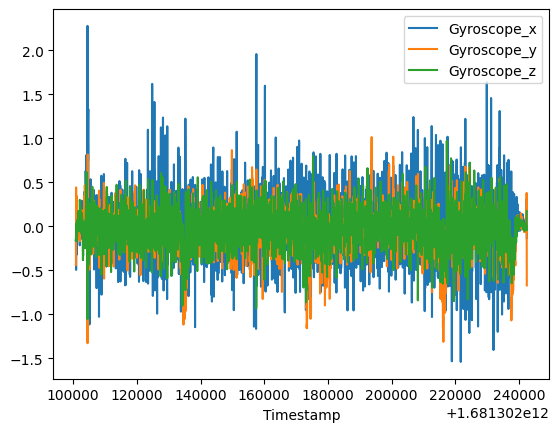

In [ ]:
# 陀螺儀
r.plot(x='Timestamp' ,y=['Gyroscope_x','Gyroscope_y','Gyroscope_z'])

<Axes: xlabel='Timestamp'>

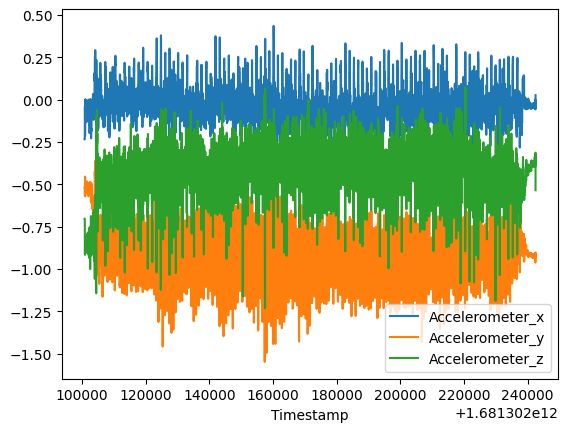

In [ ]:
# 加速度感測器
r.plot(x='Timestamp', y=['Accelerometer_x','Accelerometer_y','Accelerometer_z'])

<Axes: xlabel='Timestamp'>

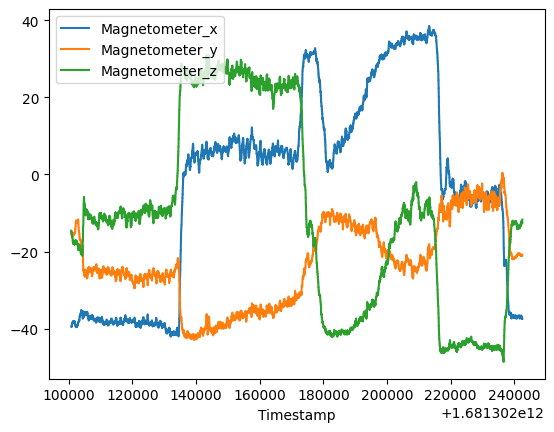

In [ ]:
r.plot(x='Timestamp', y=['Magnetometer_x','Magnetometer_y','Magnetometer_z'])

#Task1 步伐偵測

##Task1-1 
>
首先算出g，來畫出波形圖
> 
各組可套用上一次Lab所計算的方法，這邊助教使用簡單的平方相加後開根號的方法求得g

<Axes: xlabel='Timestamp'>

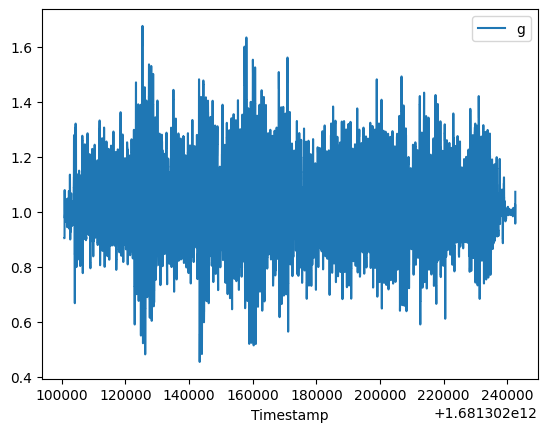

In [ ]:
######### Please Write Your Code Here #########
r = round.ffill()
r["g"] = (r["Accelerometer_x"]*r["Accelerometer_x"] + r["Accelerometer_y"]*r["Accelerometer_y"] + r["Accelerometer_z"]*r["Accelerometer_z"] )**0.5 #You can change this

# g_x = r['Accelerometer_x'].dropna()
# g_y = r['Accelerometer_y'].dropna()
# g_z = r['Accelerometer_z'].dropna()

# g0_x = g_x.mean()
# g0_y = g_y.mean()
# g0_z = g_z.mean()

# print(g0_x, g0_y, g0_z)


# verticalValue = ((g_x * g0_x) + (g_y * g0_y) + (g_z * g0_z)) / np.sqrt((g_x * g_x) + (g_y * g_y) + (g_z * g_z))

# r['g'] = verticalValue - g0_z

# r['g'] = r['g'] - r['g'].mean()

# print(r['g'].mean())

# r = r[:500]
r.plot(x='Timestamp', y=['g'])

########

##Task1-2
>
針對計算出的g作波形分析
> 
各組可以自行修改程式 使用自己的方法來計算
> 

助教提供一個範例方法為從波形中尋找每一個波峰
>
每找到一個波峰就往波峰左邊以及右邊找一個波谷
>
計算這個振福是否有大於設置的閥值(threshold)
>
如果有就把這個波的各項資訊記錄下來 當作是偵測到的一步

532
troughs:1663
           0         1         2              3              4   5         6   \
0    0.903854  1.078463  0.976718  1681302100897  1681302100997  60 -0.141569   
1    0.899046  1.052968  0.926942  1681302102693  1681302102842  60 -0.120465   
2    1.124811  1.277922  1.028139  1681302103840  1681302103990  60  0.024036   
3    1.028139  1.145155  0.667320  1681302103990  1681302104139  60  0.144662   
4    1.175018  1.320153  1.203785  1681302104339  1681302104439  60  0.044373   
..        ...       ...       ...            ...            ...  ..       ...   
99   1.112418  1.320256  0.742363  1681302229854  1681302229954  60  0.162890   
100  1.191862  1.420070  0.933164  1681302230952  1681302231201  60  0.023762   
101  0.933164  1.150906  0.683001  1681302231201  1681302231300  60  0.207720   
102  0.896872  1.073469  0.760562  1681302233895  1681302233997  60  0.191136   
103  0.985157  1.155306  0.864437  1681302235291  1681302235391  60  0.237821   

          

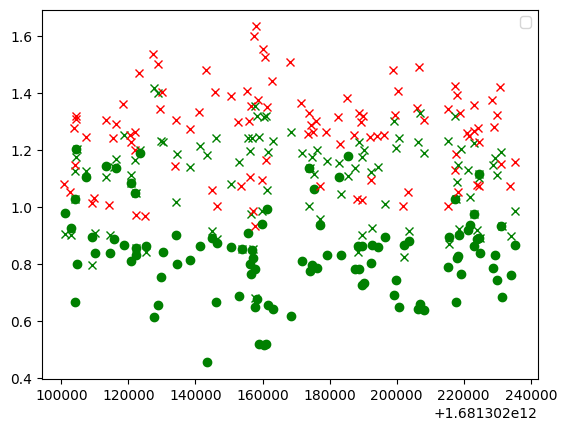

In [ ]:
#our method

import pandas as pd
import numpy as np
from scipy.signal import find_peaks, peak_prominences
#依據各組修改
step_distance=60

# 讀取數據
data = r

# 設置閥值
threshold = 0.1

# 找出波峰和波谷的索引
peaks, _ = find_peaks(data['g'], height=0.5,distance=4) # height表示峰值的閥值，這裡設為0，distance表示相鄰峰值之間的最小距離，這裡設為10
# print (len(peaks))
troughs = []
for i in range(1, len(data['g'])-1):
    if data['g'][i] < data['g'][i-1] and data['g'][i] < data['g'][i+1]:
        troughs.append(i)
    elif data['g'][i] == data['g'][i-1] and data['g'][i] < data['g'][i+1]:
        troughs.append(i)
print(f"troughs:{len(troughs)}")
# 儲存偵測到的步數的資訊
steps_info = []

# 從第一個波峰開始檢測
for p in peaks:
    # 找到這個波峰左邊最近的波谷
    left_trough_idx = None
    for i in range(p-1, -1, -1):
        if i in troughs:
            left_trough_idx = i
            break
    if left_trough_idx is None:
        continue
    low_left = data.iloc[left_trough_idx]['g']
    time_left = r['Timestamp'][left_trough_idx]
    # 找到這個波峰右邊最近的波谷
    right_trough_idx = None
    for i in range(p+1, len(data['g'])):
        if i in troughs:
            right_trough_idx = i
            break
    if right_trough_idx is None:
        continue
    low_right = data.iloc[right_trough_idx]['g']
    time_right = r['Timestamp'][right_trough_idx]

    sum_x,sum_y,sum_z = 0,0,0
    avg_g_x,avg_g_y,avg_g_z = 0,0,0
    avg_m_x,avg_m_y,avg_m_z = 0,0,0

    for i in range(left_trough_idx , right_trough_idx+1): #計算這一步內的 平均加速度avg_g 的x,y,z各分量
      sum_x += r["Accelerometer_x"][i]
      sum_y += r["Accelerometer_y"][i]
      sum_z += r["Accelerometer_z"][i]
    avg_g_x = sum_x/(right_trough_idx-left_trough_idx+1)
    avg_g_y = sum_y/(right_trough_idx-left_trough_idx+1)
    avg_g_z = sum_z/(right_trough_idx-left_trough_idx+1)
    for i in range(left_trough_idx , right_trough_idx+1): #計算這一步內的 平均磁力計avg_m 的x,y,z各分量
      sum_x += r["Magnetometer_x"][i]
      sum_y += r["Magnetometer_y"][i]
      sum_z += r["Magnetometer_z"][i]
    avg_m_x = sum_x/(right_trough_idx-left_trough_idx+1)
    avg_m_y = sum_y/(right_trough_idx-left_trough_idx+1)
    avg_m_z = sum_z/(right_trough_idx-left_trough_idx+1)
    # 計算這個振幅是否大於閥值

    if data.iloc[p]['g']-low_left > threshold and data.iloc[p]['g'] -low_right >threshold:
        # 記錄相關資訊
        #step_info = {
            
            #'Amplitude': amplitude,
            #'low_left': left_trough,
            #,
            #'low_right': right_trough,
            #'time_left':int(time_left),
            #'time_right': int(time_right),
            #'step_distance':50,
            #'avg_g_x':avg_g_x,
            #'avg_g_y':avg_g_y,
            #'avg_g_z':avg_g_z,
            #'avg_m_x':avg_m_x,
            #'avg_m_y':avg_m_y,
            #'avg_m_z':avg_m_z,
            #'timestamp':data.iloc[p]['Timestamp']
        #}
        #steps.append(step_info)
        peak = data.iloc[p]['g']
        steps_info.append([low_left,peak,low_right,time_left,time_right,step_distance,avg_g_x,avg_g_y,avg_g_z,avg_m_x,avg_m_y,avg_m_z])

# 將步數資訊轉換成DataFrame
steps_df = pd.DataFrame(steps_info)

# 顯示偵測到的步數資訊
print(steps_df)


# 将Timestamp转换成datetime格式并设置为索引
#data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data = data.set_index('Timestamp')

# 画出data['g']的曲线
steps_df = pd.DataFrame(steps_info)

for step in steps_info:
    plt.plot(step[3], step[1], 'rx')  # plot peak as a red cross
    plt.plot(step[4], step[0], 'gx')  # plot low_left as a green cross
    plt.plot(step[4], step[2], 'go')  # plot low_right as a green cross

plt.legend()
plt.show()

In [ ]:
#助教
######### Please Write Your Code Here #########
threshold = 0.2
#frequency = 200
low_left = 0
low_right = 0
time_left = 0
time_right = 0
peak = 0
step_distance = 30
index_left = 0
index_right = 0
step_info=[]

print(len(r['g']))

for i in range(1,len(r['g'])):
  if i+4 >= len(r['g']): # out of bounds
    break
  if (r['g'][i] > r['g'][i-1]) and (r['g'][i] > r['g'][i+4]):  #find peak
    peak = r['g'][i]

    for j in range(1,30): #to right side
      if i+j+4 >= len(r['g']):
        break
      if r['g'][i+j] < r['g'][i+j+4] and r['g'][i+j] < r['g'][i+j-1]:
        low_right = r['g'][i+j]
        time_right = r['Timestamp'][i+j]
        index_right = i+j
        break
    for j in range(1,30): #to left side
      if i-j-1 < 0 :
        break
      if r['g'][i-j] < r['g'][i-j+4] and r['g'][i-j] < r['g'][i-j-1]:
        low_left = r['g'][i-j]
        time_left = r['Timestamp'][i-j]
        index_left = i-j
        break
    sum_x,sum_y,sum_z = 0,0,0
    avg_g_x,avg_g_y,avg_g_z = 0,0,0
    avg_m_x,avg_m_y,avg_m_z = 0,0,0

    for i in range(index_left , index_right+1): #計算這一步內的 平均加速度avg_g 的x,y,z各分量
      sum_x += r["Accelerometer_x"][i]
      sum_y += r["Accelerometer_y"][i]
      sum_z += r["Accelerometer_z"][i]
    avg_g_x = sum_x/(index_right-index_left+1)
    avg_g_y = sum_y/(index_right-index_left+1)
    avg_g_z = sum_z/(index_right-index_left+1)
    for i in range(index_left , index_right+1): #計算這一步內的 平均磁力計avg_m 的x,y,z各分量
      sum_x += r["Magnetometer_x"][i]
      sum_y += r["Magnetometer_y"][i]
      sum_z += r["Magnetometer_z"][i]
    avg_m_x = sum_x/(index_right-index_left+1)
    avg_m_y = sum_y/(index_right-index_left+1)
    avg_m_z = sum_z/(index_right-index_left+1)

    if peak - low_left > threshold and peak - low_right > threshold:  #若振幅大於設定的閥值就把這一步記錄下來 並放進list保存 待會輸出成output
      step_info.append([low_left,peak,low_right,time_left,time_right,step_distance,avg_g_x,avg_g_y,avg_g_z,avg_m_x,avg_m_y,avg_m_z])  
    

print(step_info)
##########

8659
[[0.9720425567991081, 1.2779218043983935, 1.0281385238879075, 1681302103695, 1681302103944, 30, -0.02502727508544922, -0.7633647918701172, -0.7998561859130859, -35.71226692199707, -18.83854854106903, -21.150001525878906], [0.7986393156857384, 1.1353656193927595, 0.8256019866934274, 1681302104593, 1681302105001, 30, -0.0107647705078125, -0.8398541259765625, -0.342506103515625, -36.30068374633789, -26.28680587768555, -8.206458129882812], [0.9311226360961036, 1.2760434124936273, 0.7766232918336773, 1681302106189, 1681302106589, 30, -0.0304949951171875, -0.95211669921875, -0.5071502685546875, -37.4124333190918, -25.582039566040038, -11.384522705078124], [0.900999034584391, 1.284863000188949, 0.9296438365688426, 1681302107686, 1681302108185, 30, -0.020461082458496094, -0.9038453102111816, -0.5095548629760742, -37.652668952941895, -25.213033318519592, -12.387751579284668], [0.9149854227270632, 1.2089975339777337, 0.7942800128678612, 1681302108484, 1681302108986, 30, -0.04504591418850806

##Task1-3
上一個步驟把偵測到的步伐都收集起來
>
現在要把這些資料輸出成csv檔案
>
輸出格式不一定要跟助教相同 只要輸出你們需要的資訊即可

In [ ]:
######### Please Write Your Code Here #########

saveName = DataPath + '\'
output = {
    "Step":[],
    "TimeSpend":[],
    "Amp_left":[],
    "Amp_right":[],
    "Peak":[],
    "Timestamp":[],
    "Avg_g_x":[],
    "Avg_g_y":[],
    "Avg_g_z":[],
    "Avg_m_x":[],
    "Avg_m_y":[],
    "Avg_m_z":[],
    "Step_Distance":[]
}
df = pd.DataFrame(output)
step_count = 1

for i in step_info:
  new_df = pd.DataFrame({
      "Step":[step_count],   #偵測到的第幾步
      "TimeSpend":i[4] - i[3],#一步所花的時間
      "Amp_left":[i[0]],    #左振幅
      "Amp_right":[i[2]],    #右振幅
      "Peak":[i[1]],      #波峰
      "Timestamp":[str(i[3])+"-"+ str(i[4])],  #時間戳記
      "Avg_g_x":i[6],
      "Avg_g_y":i[7],
      "Avg_g_z":i[8],
      "Avg_m_x":i[9],
      "Avg_m_y":i[10],
      "Avg_m_z":i[11],
      "Step_Distance":i[5]    #步距
  })
  df = pd.concat([df,new_df],ignore_index=True)
  step_count=step_count+1
print(df)
df.to_csv("05_step.csv",index=False)  ##輸出結果檔名要記得

##########

      Step  TimeSpend  Amp_left  Amp_right      Peak  \
0      1.0      603.0  0.946478   0.866925  1.178829   
1      2.0      451.0  0.968458   0.838950  1.293044   
2      3.0      351.0  1.041518   0.837809  1.263940   
3      4.0      602.0  0.896202   0.858100  1.243067   
4      5.0      602.0  0.915672   0.867222  1.343908   
..     ...        ...       ...        ...       ...   
187  188.0      400.0  0.788942   0.739244  1.616806   
188  189.0      451.0  0.785725   0.669896  1.557363   
189  190.0      401.0  0.838277   0.384205  1.636094   
190  191.0      351.0  0.384205   0.763332  1.201866   
191  192.0      351.0  0.763332   0.865826  1.643982   

                       Timestamp   Avg_g_x   Avg_g_y   Avg_g_z    Avg_m_x  \
0    1681372802688-1681372803291 -0.011915 -0.949472 -0.368132 -36.356061   
1    1681372803740-1681372804191 -0.011965 -0.966115 -0.420072 -36.329193   
2    1681372804692-1681372805043 -0.012473 -0.970503 -0.388464 -35.844778   
3    1681372806095-

##Task2 步距猜測

##Task2-1
步距的猜測各組可以使用自己上網查詢的方法
>
這裡助教提供一個使用LinearRegression的方法
>
先讀取每組不同步距的步伐偵測資料檔
>
讀取想要當作參數的部分
>
設定X為自變數(各項資料如左振幅、右振幅、波峰、時間等等) Y為依變數(要猜測的步距)


In [ ]:
######### Please Write Your Code Here #########
from glob import glob

files = glob("/content/*_cm.csv")
df_list = [pd.read_csv(file) for file in files]

df = pd.concat(
    (pd.read_csv(file,usecols=['TimeSpend','Amp_left','Amp_right',"Peak","Step_Distance"],dtype={'TimeSpend':float,'Amp_left':float,'Amp_right':float,'Peak':float,'Step_Distance':float})for file in files),ignore_index=True)

X = df.iloc[:,:-1].values
Y = df.iloc[:,-1].values

print(X)
print(Y)
########

[[603.     0.95   0.87   1.18]
 [451.     0.97   0.84   1.29]
 [351.     1.04   0.84   1.26]
 ...
 [385.     0.89   0.86   1.03]
 [400.     0.86   0.89   1.2 ]
 [407.     0.92   0.92   1.12]]


##Task2-2
這邊使用的是sklearn linear model
>
各組可使用自己的方式提升準確度

In [ ]:
######### Please Write Your Code Here #########
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=777) #設定訓練大小為0.8 測試大小為0.2

reg = LinearRegression()
reg.fit(X_train,Y_train)
Y_pred = reg.predict(X_test)

np.set_printoptions(precision=2) #設定預測精準度到小數點後第2位
print(np.concatenate((Y_pred.reshape(len(Y_pred),1),Y_test.reshape(len(Y_test),1)),1)) #左邊為預測結果 右邊為真實結果

############

[[39.27 40.  ]
 [37.35 40.  ]
 [25.84 30.  ]
 [27.95 30.  ]
 [38.8  40.  ]
 [37.91 40.  ]
 [30.11 30.  ]
 [32.3  30.  ]
 [36.14 40.  ]
 [40.47 40.  ]
 [40.33 40.  ]
 [36.18 40.  ]
 [30.64 30.  ]
 [28.34 30.  ]
 [39.48 40.  ]
 [38.44 40.  ]
 [39.25 40.  ]
 [39.65 40.  ]
 [39.53 40.  ]
 [34.24 30.  ]
 [37.8  40.  ]
 [30.83 30.  ]
 [39.22 40.  ]
 [40.33 40.  ]
 [39.88 40.  ]
 [39.38 40.  ]
 [35.29 30.  ]
 [36.17 40.  ]
 [40.4  40.  ]
 [31.5  30.  ]
 [37.57 40.  ]
 [28.04 30.  ]
 [35.21 30.  ]
 [39.85 40.  ]
 [39.51 40.  ]
 [38.81 40.  ]
 [39.88 40.  ]
 [39.62 40.  ]
 [40.02 40.  ]
 [38.68 40.  ]
 [40.65 40.  ]
 [38.82 40.  ]
 [25.18 30.  ]
 [34.5  30.  ]
 [33.35 30.  ]
 [33.08 30.  ]
 [40.41 40.  ]
 [31.22 30.  ]
 [28.68 30.  ]
 [32.85 30.  ]
 [40.24 40.  ]
 [36.35 40.  ]
 [40.17 40.  ]
 [31.71 30.  ]
 [30.38 30.  ]
 [34.95 30.  ]
 [40.11 40.  ]
 [31.13 30.  ]
 [39.24 40.  ]
 [39.39 40.  ]
 [40.48 40.  ]
 [38.43 40.  ]
 [30.93 30.  ]
 [30.78 30.  ]
 [31.54 30.  ]
 [35.77 30.  ]
 [33.33 30

##Task3 計算前進方向

##Task3-1
這個部分希望同學計算出當前步伐的前進方向
>
判斷方法不可以使用經緯度
>
這邊助教提供的方法為收集偵測到的步伐時間內的平均加速度在水平方向上的分量
>
以及磁力計在水平方向上的分量
>
因為磁力計在水平方向指向南方 所以求出這兩個像量的夾角就可以得到前進方向

In [ ]:
######### Please Write Your Code Here #########
new_df = pd.read_csv("/content/30_cm.csv") #讀取步伐資料檔
dir_list = []

for i in range(len(new_df["Step"])):
  avg_g = np.array([new_df["Avg_g_x"][i], new_df["Avg_g_y"][i] ,new_df["Avg_g_z"][i]])
  avg_m = np.array([new_df["Avg_m_x"][i], new_df["Avg_m_y"][i] ,new_df["Avg_m_z"][i]])
  z = np.array([0,0,-1]) #z軸單位向量 與avg_g同向
  u = z - (np.dot(z,avg_g)/np.dot(avg_g,avg_g)*z) #重力加速度在水平方向分量 使用
  v = avg_m - ((np.dot(avg_g,avg_m)/np.dot(avg_g,avg_g))*avg_m) #磁力計在水平方向朝南 使用avg_m - (avg_m在avg_g的投影向量)
  cos = np.dot(u,v) / ((np.dot(u,u)**0.5) * np.dot(v,v)**0.5) #計算兩個COS值 使用高中所學公式
  cross_ans = np.dot(np.cross(v,u) , avg_g) #判斷夾角偏向東還是西 使用u與v外積後和avg_g內積 判斷正負值來得知往左還往右
  if cross_ans < 0: #與avg_m 反向 右手定則由南邊往左偏移
    if cos >=0.7071 and cos <=1:
      dir = "南"
    elif cos <0.7071 and cos >0:
      dir = "東"
    elif cos <0 and cos >=-0.7071:
      dir = "東"
    elif cos < -0.7071 and cos >-1:
      dir = "北"
  elif cross_ans > 0: #與avg_m 反向 右手定則由南邊往左偏移
    if cos >=0.7071 and cos <=1:
      dir = "南"
    elif cos <0.7071 and cos >0:
      dir = "西"
    elif cos <0 and cos >=-0.7071:
      dir = "西"
    elif cos < -0.7071 and cos >-1:
      dir = "北"
  dir_list.append(dir)
print(dir_list)
  #1 ~ 0.7071 0度~45度
  #0.7071 ~ 0 45度~90度
  #0 ~ -0.7071 90度 ~ 135度
  #-0.7071 ~ -1 135度~180度
###########

['東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '東', '西', '西', '西', '西', '西', '西', '西', '西', '西', '南', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '西', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北', '北']


##Task4 將偵測到的步伐畫在地圖上

In [ ]:
import folium

# 設定地圖中心點座標
center = [24.7868797,120.9974383]

ori_df = pd.read_csv("/content/drive/MyDrive/Map/Lab3/Data/05_50cm.csv")
result_df = pd.read_csv("/content/05_50_2_cm.csv")
#1681302721895-1681302722263 Result的欄位內容取前13字元
result_df['Timestamp'] = result_df['Timestamp'].str[:13].astype(int) 
print(result_df['Timestamp'])
#print(result_df.dtypes)
merge_df = pd.merge(ori_df,result_df,left_on="Timestamp",right_on='Timestamp')
print(merge_df.dtypes)
merge_df = merge_df.dropna(subset=['Latitude'])
print(merge_df)
merge_df = merge_df.dropna(subset=['Longitude'])
print(merge_df)

# 建立地圖物件，zoom_start 是縮放等級
map = folium.Map(location=center, zoom_start=40)

# 要標記的 GPS 位置列表
locations = merge_df[['Latitude','Longitude']].values.tolist()

# 在地圖上標記 GPS 位置
for location in locations:
    marker = folium.Marker(location=location)
    marker.add_to(map)